# Lab6 Black-Scholes Norbert Frydrysiak

We need to generate lots of random numbers:
$$
S_0 e^{\sigma \sqrt{T} Z + (r - \frac{\sigma^2}{2}) T}
$$
where $Z \sim N(0,1)$

We are trying to estimate the price of a option with strike $K$:
$$
(S_T - K)^+
$$

## Import

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm

np.random.seed(42)

In [2]:
S0 = 100
r = 0.1
T = 1
sigma = 1
K_low = 80
K_high = 120

## Exact price

In [3]:
def d(S0, K, r, T, sigma):
    """
    Calculate d1 and d2 for the Black-Scholes formula.
    d1 is d with plus sign and d2 is d with minus sign.
    """
    d1 = (np.log(S0/K) + (r + sigma**2/2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return d1, d2

def BS(S0, K, r, T, sigma):
    """
    Calculate the Black-Scholes price of a call option.
    """
    d1, d2 = d(S0, K, r, T, sigma)
    return S0 * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
call_in_the_money = BS(S0, K_low, r, T, sigma)
print(f"Exact price for K={K_low}: {call_in_the_money}")
call_out_of_the_money = BS(S0, K_high, r, T, sigma)
print(f"Exact price for K={K_high}: {call_out_of_the_money}")

Exact price for K=80: 48.36598654140403
Exact price for K=120: 35.76934353937068


## 1: Estimation without variance reduction

In [4]:
def cumulated_mean(values):
    """
    Calculate the cumulated mean of a list of values.
    """
    n = len(values)
    cumulated_mean = np.zeros(n)
    curr_sum = 0
    for i in range(n):
        curr_sum += values[i]
        cumulated_mean[i] = curr_sum / (i + 1)
    return cumulated_mean

In [5]:
n=10_000
Z = np.random.normal(size=n)
S_T = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - sigma**2 / 2) * T)
discount = np.exp(-r * T)
prices_out_of_the_money = np.maximum(S_T - K_high, 0)
prices_in_the_money = np.maximum(S_T - K_low, 0)
estimate_call_out_of_the_money = np.cumsum(discount*prices_out_of_the_money) / np.arange(1, n + 1)
estimate_call_in_the_money = np.cumsum(discount*prices_in_the_money) / np.arange(1, n + 1)
print(f"Estimate for K={K_low}: {estimate_call_in_the_money[-1]}")
print(f"Estimate for K={K_high}: {estimate_call_out_of_the_money[-1]}")
divider = np.arange(0, n)
divider[divider == 0] = 1
variance_estimator_out_of_the_money = np.cumsum((estimate_call_out_of_the_money - cumulated_mean(estimate_call_out_of_the_money))**2)/divider
variance_estimator_in_the_money = np.cumsum((estimate_call_in_the_money - cumulated_mean(estimate_call_in_the_money))**2)/divider
print(f"Variance estimator for K={K_low}: {variance_estimator_in_the_money[-1]}")
print(f"Variance estimator for K={K_high}: {variance_estimator_out_of_the_money[-1]}")

Estimate for K=80: 48.67053366960447
Estimate for K=120: 36.12740763908507
Variance estimator for K=80: 6.375193550335037
Variance estimator for K=120: 4.9474919140703895


Plotting estimates


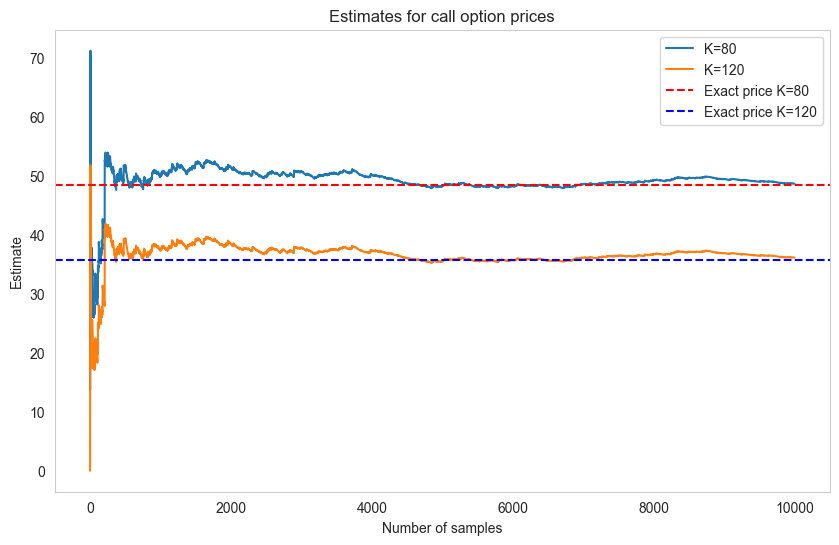

In [6]:
print("Plotting estimates")
plt.figure(figsize=(10, 6))
plt.plot(estimate_call_in_the_money, label=f"K={K_low}")
plt.plot(estimate_call_out_of_the_money, label=f"K={K_high}")
plt.axhline(call_in_the_money, color='red', linestyle='--', label=f"Exact price K={K_low}")
plt.axhline(call_out_of_the_money, color='blue', linestyle='--', label=f"Exact price K={K_high}")
plt.xlabel("Number of samples")
plt.ylabel("Estimate")
plt.title("Estimates for call option prices")
plt.legend()
plt.grid()
plt.show()

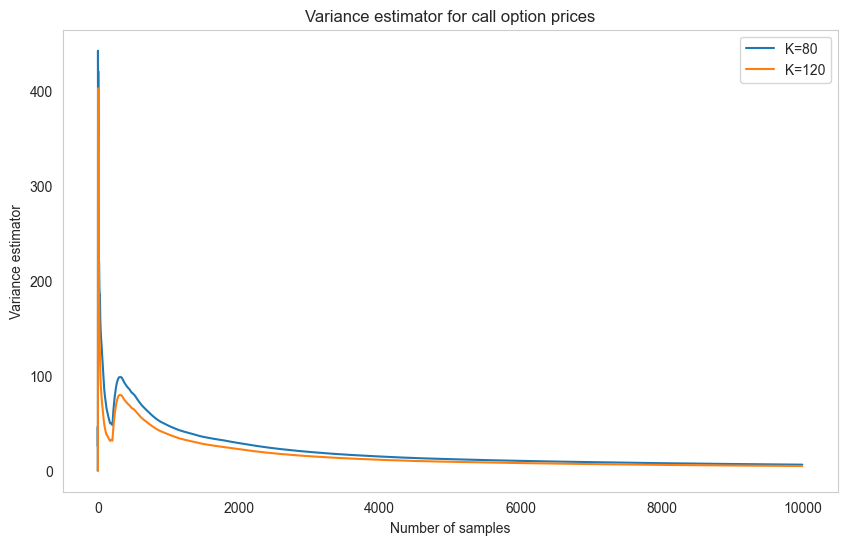

In [7]:
plt.figure(figsize=(10, 6))
plt.plot(variance_estimator_in_the_money, label=f"K={K_low}")
plt.plot(variance_estimator_out_of_the_money, label=f"K={K_high}")
plt.xlabel("Number of samples")
plt.ylabel("Variance estimator")
plt.title("Variance estimator for call option prices")
plt.legend()
plt.grid()
plt.show()

## 1a: Control variates
I take control variate
$$
e^{-rT} S_T
$$
$$
E[e^{-rT} S_T] = S_0
$$


K = 80
Last Variance Estimator Control Variates: 0.1008
Last Estimator Control Variates: 48.2198


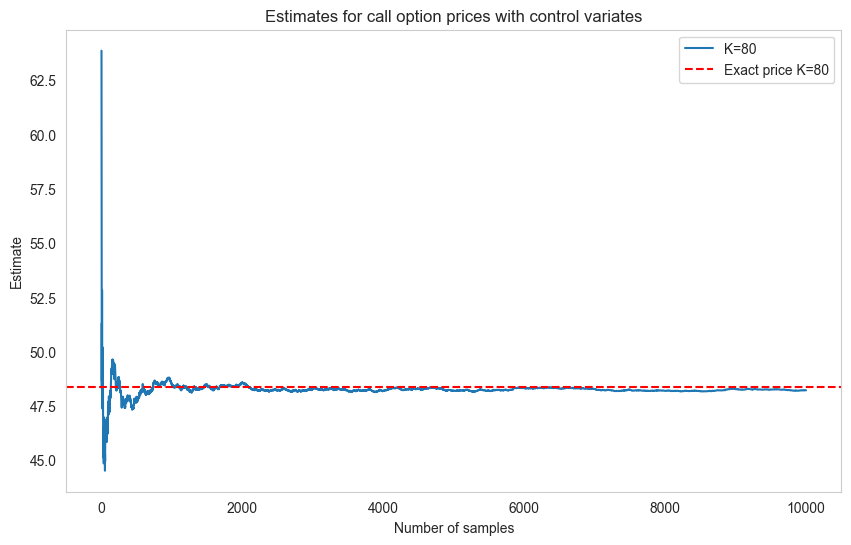

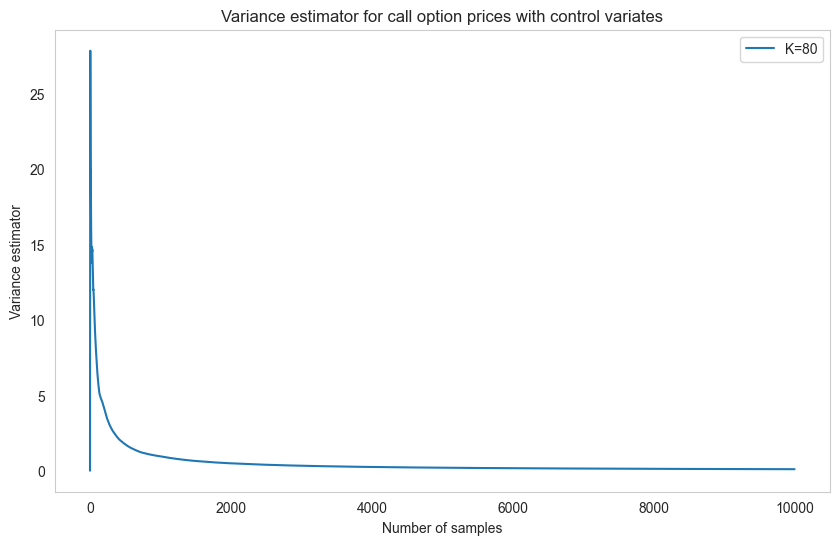


K = 120
Last Variance Estimator Control Variates: 0.3086
Last Estimator Control Variates: 35.6570


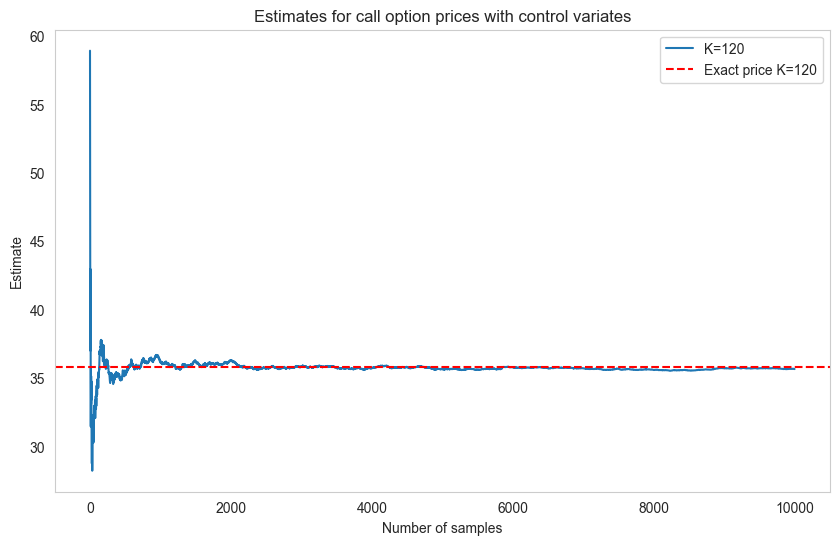

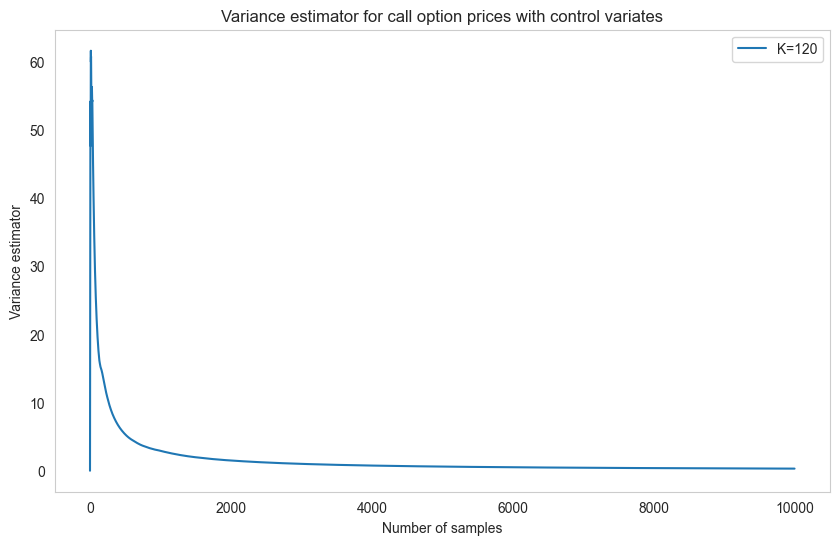

In [8]:
Ks = [80, 120]
exact_prices = [call_in_the_money, call_out_of_the_money]

Z = np.random.randn(n)
discount_factor = np.exp(-r * T)
ST = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - 0.5 * sigma**2) * T)
control_var = discount_factor * ST
control_mean = S0
control_variates_estimators= [None ,None ]

for K, exact_price in zip(Ks, exact_prices):
    payoff = discount_factor * np.maximum(ST - K, 0)

    beta = np.cov(payoff, control_var, ddof=1)[0, 1] / np.var(control_var, ddof=1)
    adjusted_payoff = payoff - beta * (control_var - control_mean)

    cv_cumsum = np.cumsum(adjusted_payoff)
    cv_estimators = cv_cumsum / np.arange(1, n + 1)
  
    cv_var_estimators = np.cumsum((cv_estimators - cumulated_mean(cv_estimators))**2)/divider

    print(f"\nK = {K}")
    print(f"Last Variance Estimator Control Variates: {cv_var_estimators[-1]:.4f}")
    print(f"Last Estimator Control Variates: {cv_estimators[-1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(cv_estimators, label=f"K={K}")
    plt.axhline(exact_price, color='red', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with control variates")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(cv_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with control variates")
    plt.legend()
    plt.grid()
    plt.show()
    if K == 80: control_variates_estimators[0] = cv_estimators
    if K == 120: control_variates_estimators[1] = cv_estimators

## 1b: Control variates Turbo

the method of control variates in the turbo version: as a control variate, choose $\hat{b}^* S_T$, where $\hat{b}^*$ is the optimal estimator (minimizing the appropriate variance) of the parameter value $b^*$ given by
$$
\hat{b}^* = \frac{\sum_{i=1}^n (X_i - \bar{X})(Y_i - \bar{Y})}{\sum_{i=1}^n (Y_i - \bar{Y})^2} \approx \frac{\text{Cov}[X,Y]}{\text{Var}[Y]} = b^*,
$$
where the vectors $(X_i, Y_i)_{i=1}^n$ are i.i.d. from the distribution $(e^{-rT}(S_T - K)^+, S_T)$.



K = 80
Last Variance Estimator Control Variates Turbo: 0.8274
Last Estimator Control Variates Turbo: 48.3449


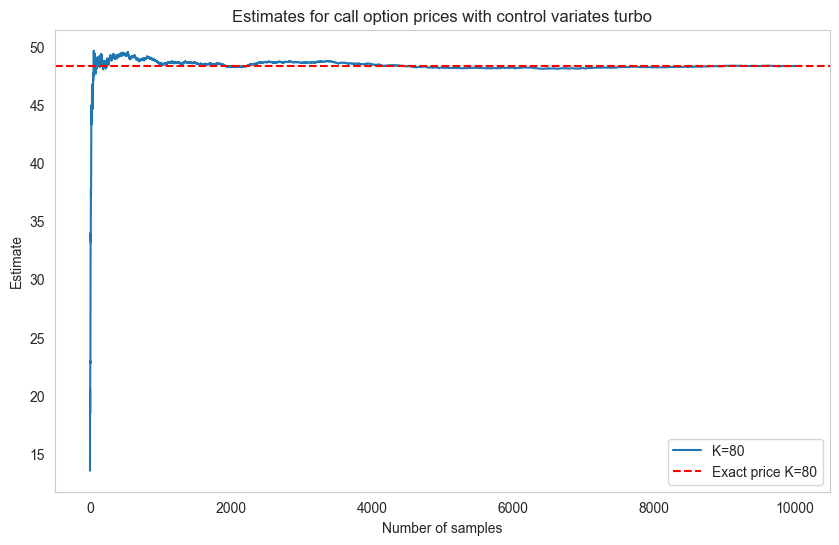

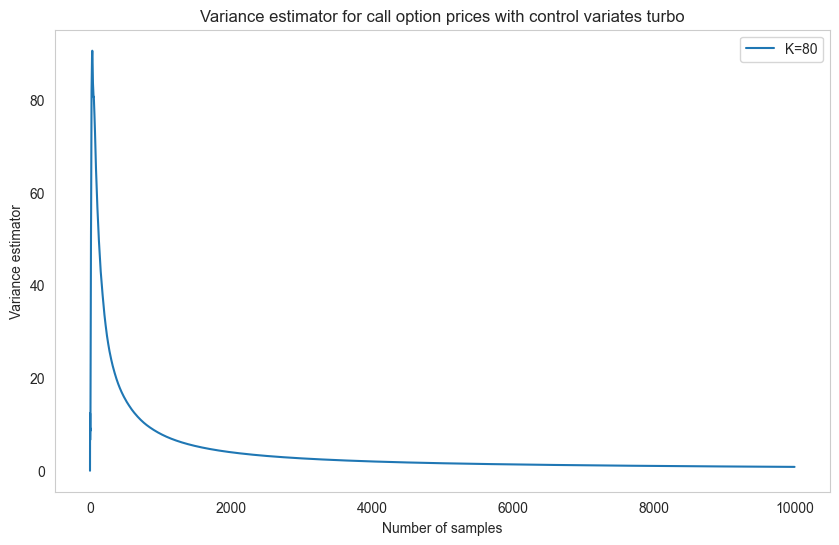


K = 120
Last Variance Estimator Control Variates Turbo: 1.4631
Last Estimator Control Variates Turbo: 35.6890


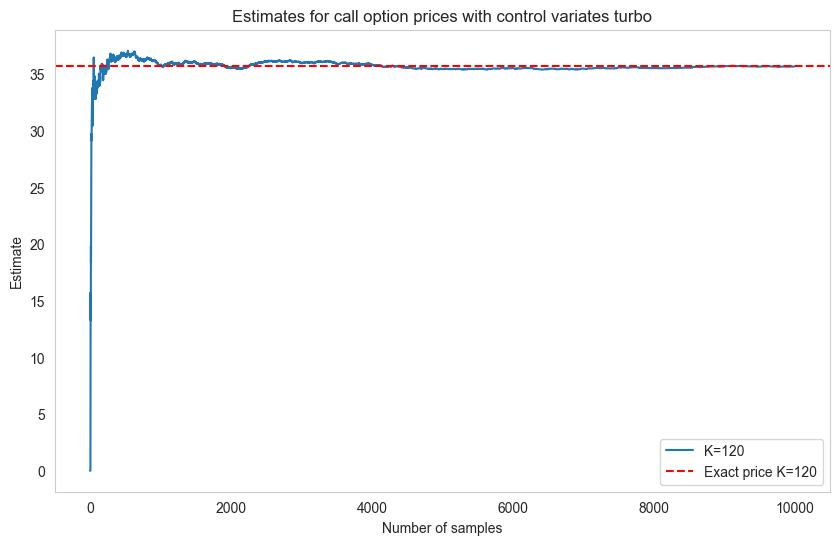

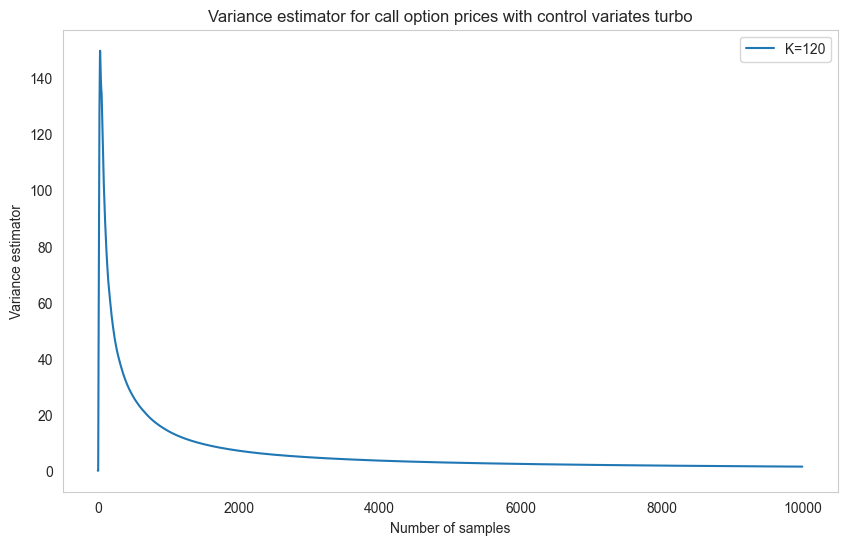

In [9]:
control_variates_turbo_estimators = [None, None]

Z = np.random.randn(n)
discount_factor = np.exp(-r * T)
ST = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - 0.5 * sigma**2) * T)
control_mean = S0 * np.exp(r * T)
for K, exact_price in zip(Ks, exact_prices):
    payoff = discount_factor * np.maximum(ST - K, 0)
    Y = ST 
    Y_mean = np.cumsum(Y) / np.arange(1, n + 1)
    X_mean = np.cumsum(payoff) / np.arange(1, n + 1)
    cov_cumsum = np.cumsum((payoff - X_mean) * (Y - Y_mean))
    varY_cumsum = np.cumsum((Y - Y_mean)**2)
    
    varY_cumsum[varY_cumsum == 0] = 1e-8
    b_star = cov_cumsum / varY_cumsum
    adjusted_payoff = payoff - b_star *(ST - control_mean)
    cv_cumsum = np.cumsum(adjusted_payoff)
    cv_estimators = cv_cumsum / np.arange(1, n + 1)
    cv_var_estimators = np.cumsum((cv_estimators - cumulated_mean(cv_estimators))**2)/divider
    print(f"\nK = {K}")
    print(f"Last Variance Estimator Control Variates Turbo: {cv_var_estimators[-1]:.4f}")
    print(f"Last Estimator Control Variates Turbo: {cv_estimators[-1]:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(cv_estimators, label=f"K={K}")
    plt.axhline(exact_price, color='red', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with control variates turbo")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(cv_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with control variates turbo")
    plt.legend()
    plt.grid()
    plt.show()
    if K == 80: control_variates_turbo_estimators[0] = cv_estimators
    if K == 120: control_variates_turbo_estimators[1] = cv_estimators

## 1c: Antithetic variates
$$
S'_T = S_0 e^{\sigma \sqrt{T} (-Z) + (r - \frac{\sigma^2}{2}) T}
$$


K = 80
Last Variance Estimator Antithetic Variates: 4.1811
Last Estimator Antithetic Variates: 48.9402


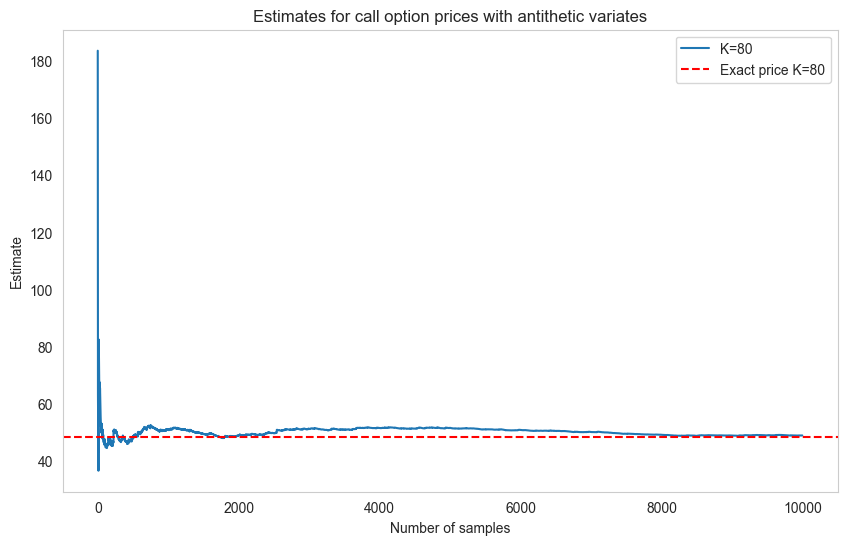

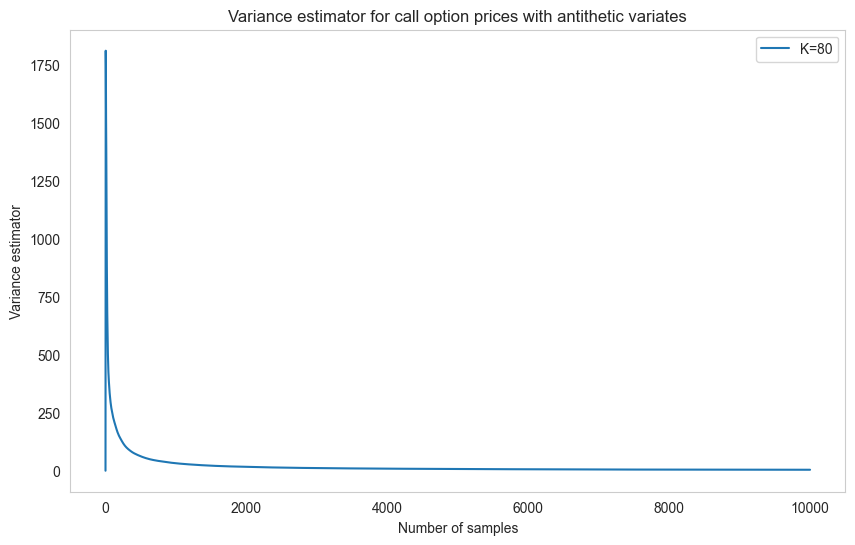


K = 120
Last Variance Estimator Antithetic Variates: 3.7729
Last Estimator Antithetic Variates: 36.2880


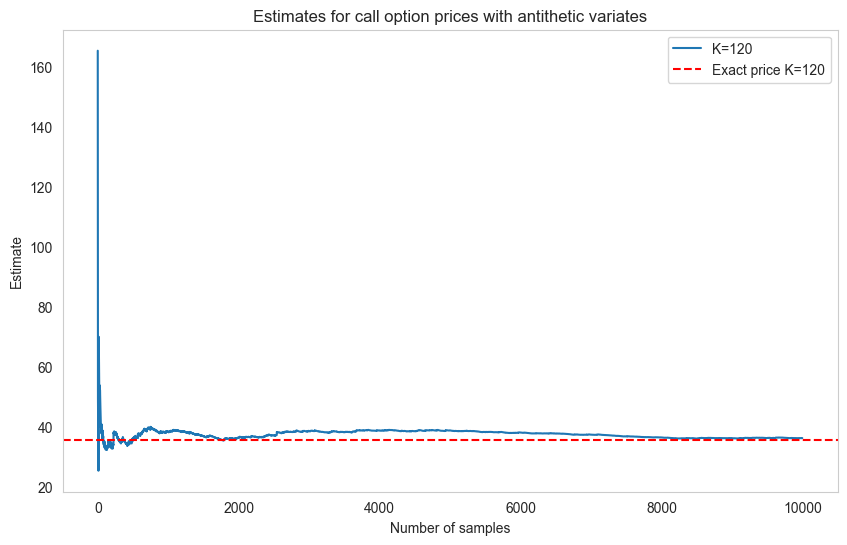

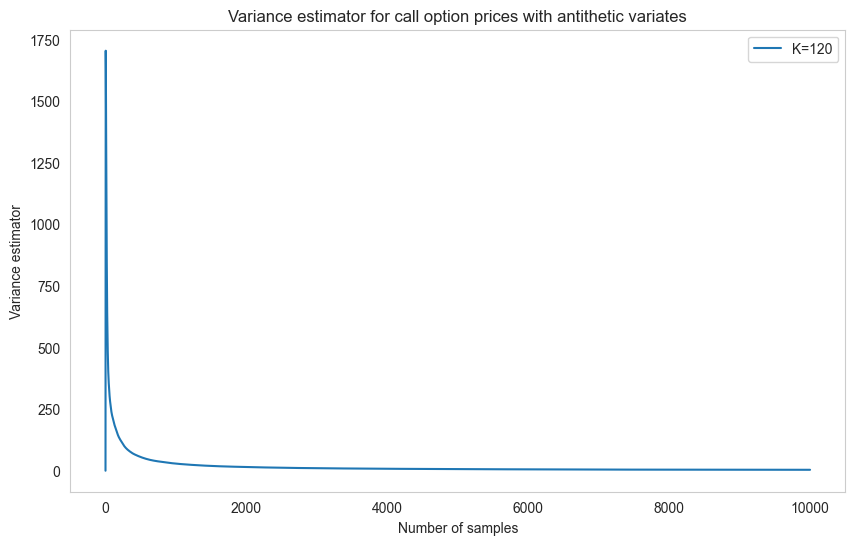

In [10]:
antithetic_variates_estimators = [None, None]
Z = np.random.randn(n)
discount_factor = np.exp(-r * T)
ST = S0 * np.exp(sigma * np.sqrt(T) * Z + (r - 0.5 * sigma**2) * T)
ST_neg = S0 * np.exp(sigma * np.sqrt(T) * (-Z) + (r - 0.5 * sigma**2) * T)
for K, exact_price in zip(Ks, exact_prices):
    payoff = discount_factor * np.maximum(ST - K, 0)
    payoff_neg = discount_factor * np.maximum(ST_neg - K, 0)
    antithetic_payoff = (payoff + payoff_neg) / 2
    antithetic_cumsum = np.cumsum(antithetic_payoff)
    antithetic_estimators = antithetic_cumsum / np.arange(1, n + 1)
    antithetic_var_estimators = np.cumsum((antithetic_estimators - cumulated_mean(antithetic_estimators))**2)/divider
    print(f"\nK = {K}")
    print(f"Last Variance Estimator Antithetic Variates: {antithetic_var_estimators[-1]:.4f}")
    print(f"Last Estimator Antithetic Variates: {antithetic_estimators[-1]:.4f}")
    
    plt.figure(figsize=(10, 6))
    plt.plot(antithetic_estimators, label=f"K={K}")
    plt.axhline(exact_price, color='red', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with antithetic variates")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(antithetic_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with antithetic variates")
    plt.legend()
    plt.grid()
    plt.show()
    if K == 80: antithetic_variates_estimators[0] = antithetic_estimators
    if K == 120: antithetic_variates_estimators[1] = antithetic_estimators

## 1d: Stratified sampling
We define layers based on the partition of $W_T$. Let $k$ be the number of layers and consider
$$
\mathbb{E}_{P^*}[e^{-rT}(S_T - K)^+] = \sum_{i=1}^k \mathbb{E}_{P^*}[e^{-rT}(S_T - K)^+ | W_T \in A_i]p_i,
$$
where the partition $(A_i)_i$ is chosen such that $P(W_T \in A_i) = p_i = \frac{1}{k}$.
To generate a variate from the distribution of $W_T | W_T \in A_i$, we can observe that (when $A_i = [a_i, a_{i+1}]$)
$$
(W_T | W_T \in A_i) \overset{d}{=} \sqrt{T} \Phi^{-1}\left(\frac{i-1+U}{k}\right), \quad i=1,\dots,k,
$$
where $U \sim U([0,1])$. Assume proportional allocation, i.e., $n_1 = \dots = n_k = \frac{n}{k}$.



K = 80
Last Variance Estimator Stratified Sampling: 4.8008
Last Estimator Stratified Sampling: 48.4905


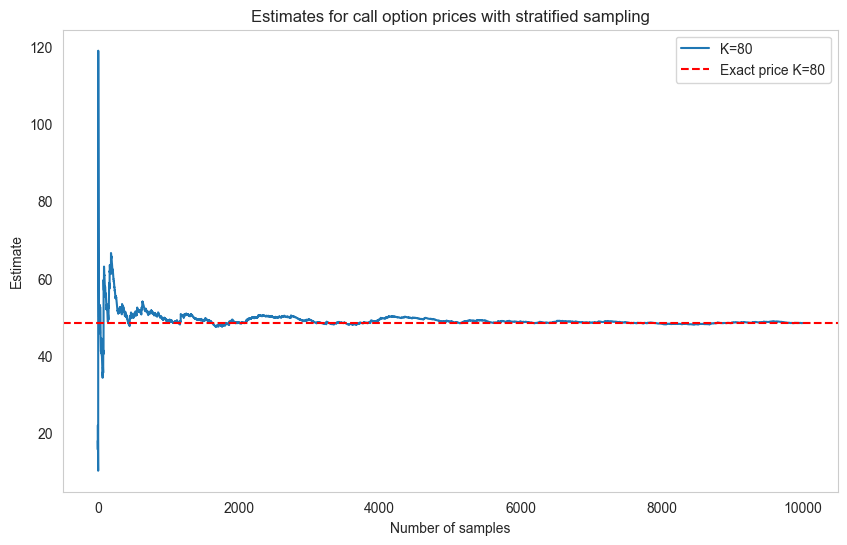

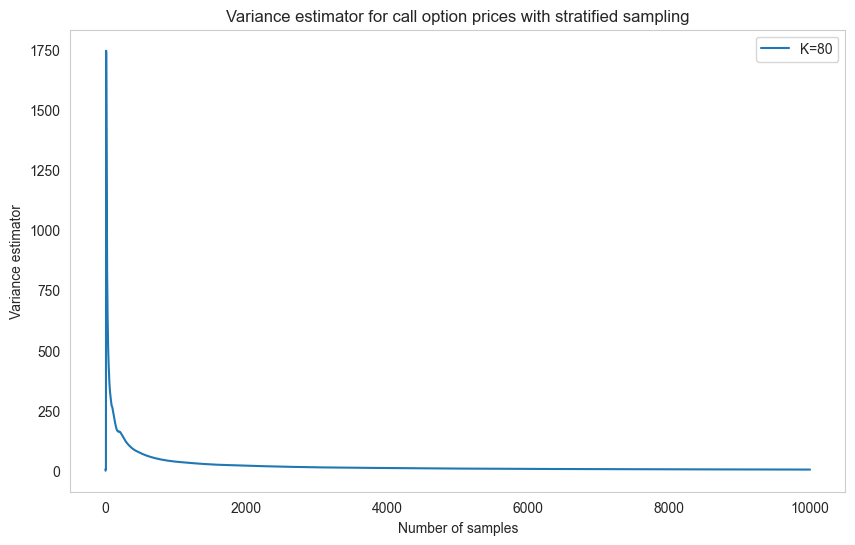


K = 120
Last Variance Estimator Stratified Sampling: 4.6536
Last Estimator Stratified Sampling: 35.9418


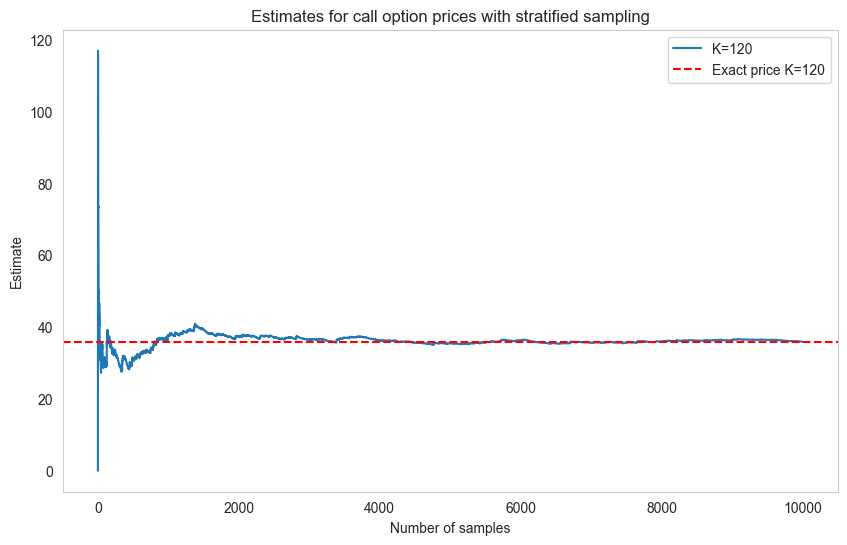

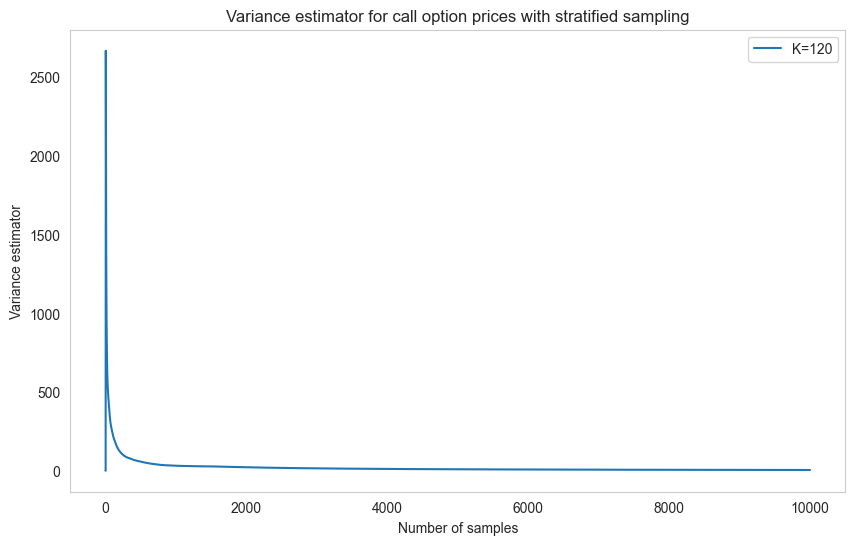

In [11]:
stratified_variates_estimators = [None, None]
k=100
n_per_layer = n // k
stratified_payoff = np.zeros(n)
for K,exact_price in zip(Ks,exact_prices):
    U=np.random.uniform(size = n_per_layer)
    for i in range(k):
        quantile = (i + U) / k
        WT = np.sqrt(T) * norm.ppf(quantile)
        ST = S0 * np.exp(sigma * WT + (r - 0.5 * sigma**2) * T)
        payoff = discount_factor * np.maximum(ST - K, 0)
        stratified_payoff[i*n_per_layer:(i+1)*n_per_layer] = payoff
    stratified_payoff = np.random.permutation(stratified_payoff) #shuffle the stratified payoffs
    stratified_cumsum = np.cumsum(stratified_payoff)
    stratified_estimators = stratified_cumsum / np.arange(1, n + 1)
    stratified_var_estimators = np.cumsum((stratified_estimators - cumulated_mean(stratified_estimators))**2)/divider
    print(f"\nK = {K}")
    print(f"Last Variance Estimator Stratified Sampling: {stratified_var_estimators[-1]:.4f}")
    print(f"Last Estimator Stratified Sampling: {stratified_estimators[-1]:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(stratified_estimators, label=f"K={K}")
    plt.axhline(exact_price, color='red', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with stratified sampling")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(stratified_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with stratified sampling")
    plt.legend()
    plt.grid()
    plt.show()
    if K == 80: stratified_variates_estimators[0] = stratified_estimators
    if K == 120: stratified_variates_estimators[1] = stratified_estimators

## 1e: Importance sampling
we have
$$
\mathbb{E}_{P^*}[e^{-rT}(S_T - K)^+] = \mathbb{E}_{P^*}\left[ e^{-rT} \left(S_0 e^{\sigma W_T + (r - \frac{\sigma^2}{2})T} - K\right)^+ \right]
$$
$$
= \mathbb{E}_{P}\left[ e^{-rT} \left(S_0 e^{\sigma Y + (r - \frac{\sigma^2}{2})T} - K\right)^+ \frac{f_{W_T}(Y)}{f_Y(Y)} \right],
$$
where $Y$ has a normal distribution $N(\mu, T)$ (with respect to the measure $P^*$). Investigate the impact of changing the parameter $\mu \in \mathbb{R}$ on the speed of convergence (variance of the estimator).


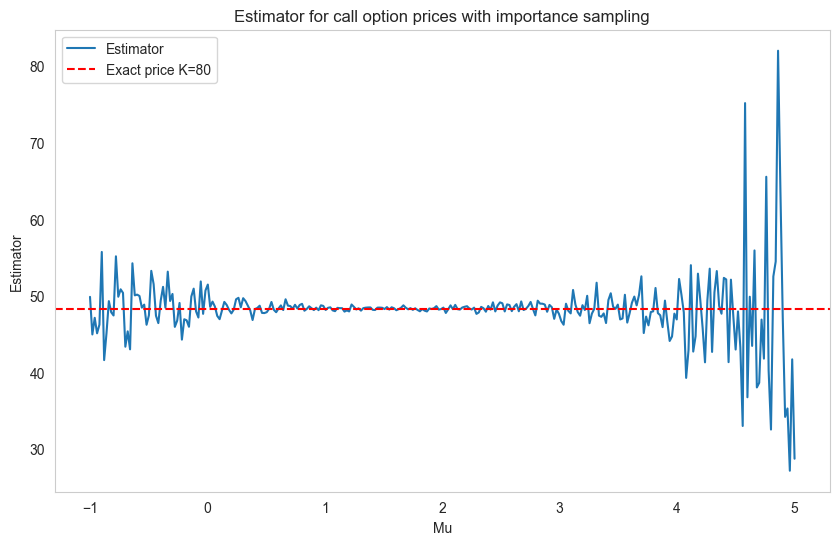

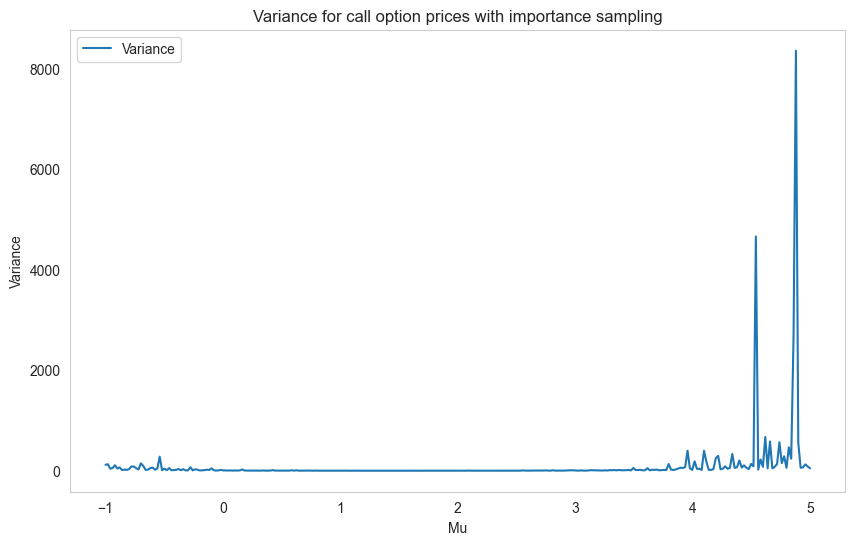

Best mu: 0.6053511705685619
Best estimator: 48.365039069344455


In [12]:
mu_values = np.linspace(-1, 5, 300)
last_estimators = []
last_variances = []
best_mu = 0
best_importance = None
for mu in mu_values:
    Z = np.random.randn(n)
    Y = np.sqrt(T) * Z + mu
    ST_mu = S0 * np.exp(sigma * Y + (r - 0.5 * sigma**2) * T)
    K=Ks[0]
    exact_price= exact_prices[0]
    divided_densities = np.exp((-Y*mu+0.5*mu**2)/(T**2))
    importance_payoff = discount_factor * np.maximum(ST_mu - K, 0) * divided_densities
    importance_cumsum = np.cumsum(importance_payoff)
    importance_estimators = importance_cumsum / np.arange(1, n + 1)
    importance_var_estimators = np.cumsum((importance_estimators - cumulated_mean(importance_estimators))**2)/divider
    last_estimators.append(importance_estimators[-1])
    last_variances.append(importance_var_estimators[-1])
    if best_importance is None or abs(importance_estimators[-1] -exact_price) < abs(best_importance - exact_price):
        best_importance = importance_estimators[-1]
        best_mu = mu

plt.figure(figsize=(10, 6))
plt.plot(mu_values, last_estimators, label="Estimator")
plt.axhline(call_in_the_money, color='red', linestyle='--', label=f"Exact price K={K_low}")
plt.xlabel("Mu")
plt.ylabel("Estimator")
plt.title("Estimator for call option prices with importance sampling")
plt.legend()
plt.grid()
plt.show()
plt.figure(figsize=(10, 6))
plt.plot(mu_values, last_variances, label="Variance")
plt.xlabel("Mu")
plt.ylabel("Variance")
plt.title("Variance for call option prices with importance sampling")
plt.legend()
plt.grid()
plt.show()
print(f"Best mu: {best_mu}")
print(f"Best estimator: {best_importance}")


K = 80
Last Variance Estimator Importance Sampling: 1.1272
Last Estimator Importance Sampling: 48.0059


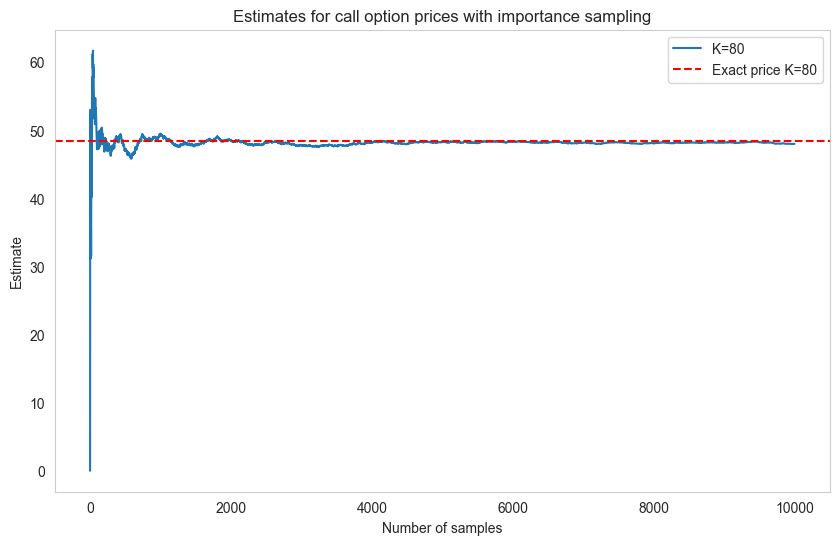

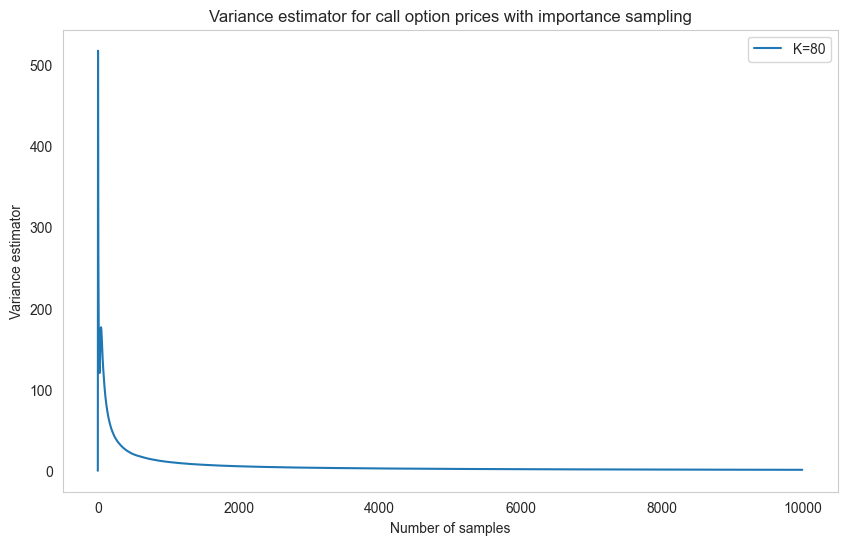


K = 120
Last Variance Estimator Importance Sampling: 0.8902
Last Estimator Importance Sampling: 36.1415


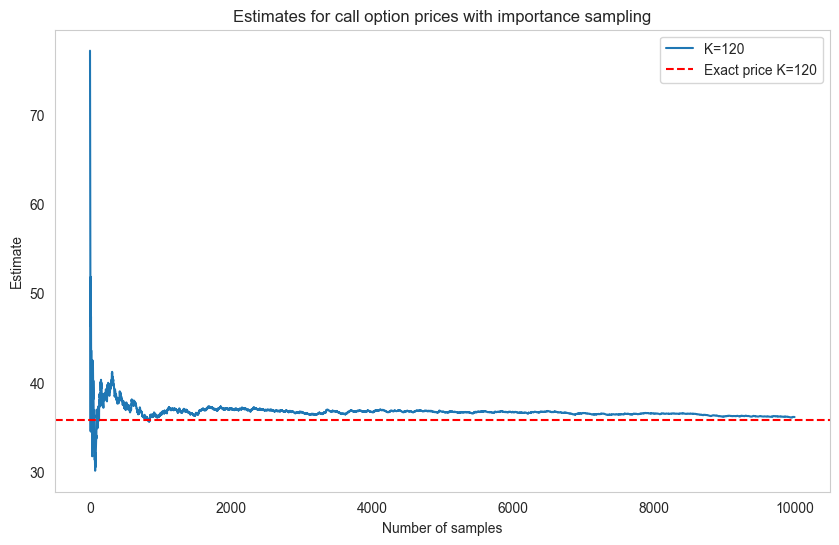

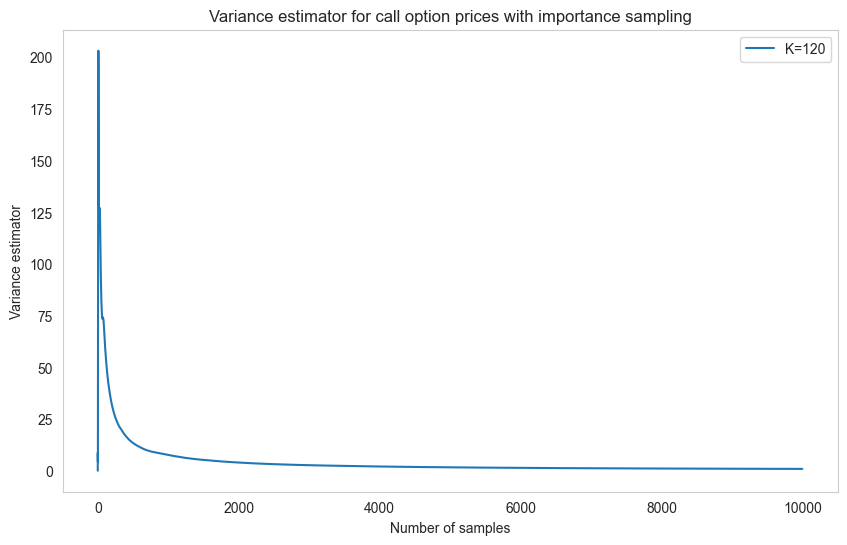

In [13]:
#we take the best mu and plot the estimators for K=80 and K=120
importance_estimators_best = [None, None]
for K, exact_price in zip(Ks, exact_prices):
    Z = np.random.randn(n)
    Y = np.sqrt(T) * Z + best_mu
    ST_mu = S0 * np.exp(sigma * Y + (r - 0.5 * sigma**2) * T)
    divided_densities = np.exp((-Y*best_mu+0.5*best_mu**2)/(T**2))
    importance_payoff = discount_factor * np.maximum(ST_mu - K, 0) * divided_densities
    importance_cumsum = np.cumsum(importance_payoff)
    importance_estimators = importance_cumsum / np.arange(1, n + 1)
    importance_var_estimators = np.cumsum((importance_estimators - cumulated_mean(importance_estimators))**2)/divider
    print(f"\nK = {K}")
    print(f"Last Variance Estimator Importance Sampling: {importance_var_estimators[-1]:.4f}")
    print(f"Last Estimator Importance Sampling: {importance_estimators[-1]:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(importance_estimators, label=f"K={K}")
    plt.axhline(exact_price, color='red', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with importance sampling")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(importance_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with importance sampling")
    plt.legend()
    plt.grid()
    plt.show()
    if K == 80: importance_estimators_best[0] = importance_estimators
    if K == 120: importance_estimators_best[1] = importance_estimators

## 1additional: Comparison of methods

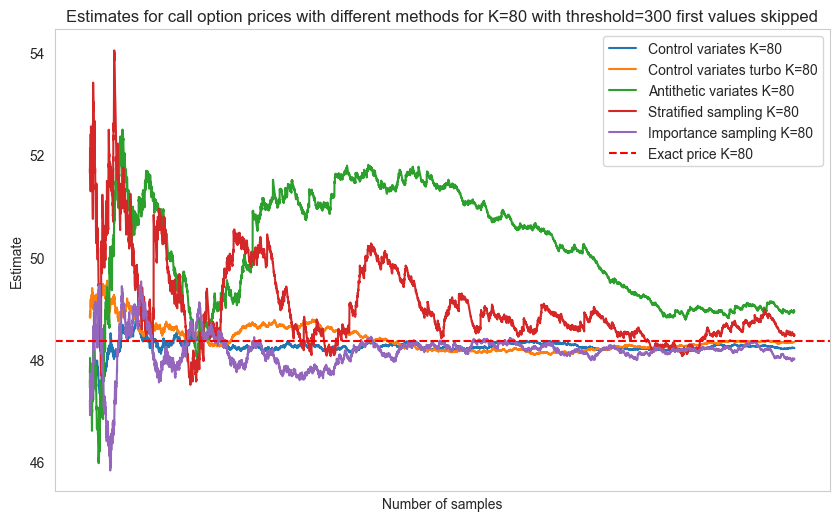

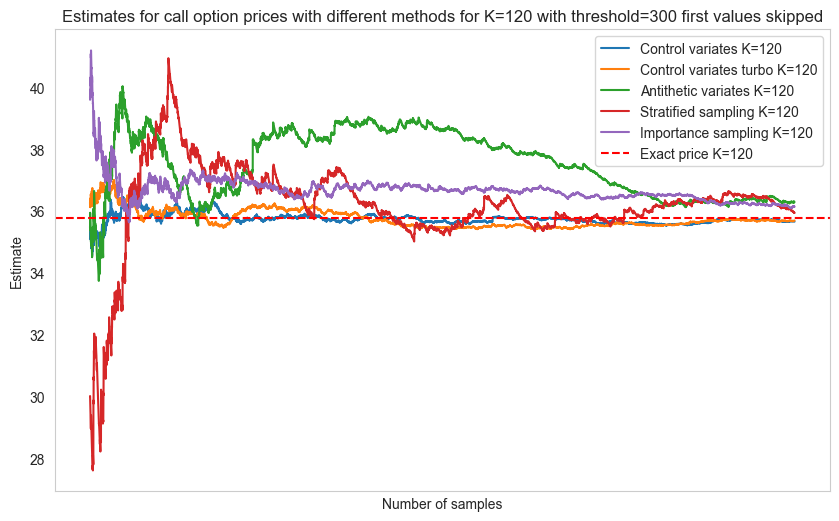

In [14]:
threshold = 300
for i in range(2):
    plt.figure(figsize=(10, 6))
    plt.plot(control_variates_estimators[i][threshold:], label=f"Control variates K={Ks[i]}")
    plt.plot(control_variates_turbo_estimators[i][threshold:], label=f"Control variates turbo K={Ks[i]}")
    plt.plot(antithetic_variates_estimators[i][threshold:], label=f"Antithetic variates K={Ks[i]}")
    plt.plot(stratified_variates_estimators[i][threshold:], label=f"Stratified sampling K={Ks[i]}")
    plt.plot(importance_estimators_best[i][threshold:], label=f"Importance sampling K={Ks[i]}")
    plt.axhline(exact_prices[i], color='red', linestyle='--', label=f"Exact price K={Ks[i]}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title(f"Estimates for call option prices with different methods for K={Ks[i]} with threshold={threshold} first values skipped")
    plt.legend()
    plt.grid()
    plt.xticks([])
    plt.show()
    

## 2: Asian option 
Price an Asian option payoff in the Black-Scholes model, given by:
$$
\left( \frac{1}{N} \sum_{i=1}^N S_{T_i} - K \right)^+.
$$

Apart from "pure" Monte Carlo, use the control variate method for the variable $Y = \left( \left( \prod_{i=1}^N S_{T_i} \right)^{1/N} - K \right)^+$. For this purpose, the value (analytical formula) of the payoff $Y$ will be needed, i.e.:
$$
\mathbb{E} \left[ e^{-rT} \left( \left( \prod_{i=1}^N S_{T_i} \right)^{1/N} - K \right)^+ \right].
$$

### My Modification
$$
\mathbb{E} \left[ (S_0 e^{\alpha Z + \beta} - K)^+ \right] = \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\infty} (S_0e^{\alpha x + \beta} - K)^+ e^{-x^2/2} dx
$$
$$
= \begin{cases}
    \frac{1}{\sqrt{2\pi}} \int_{\frac{\log \frac{K}{S_0} - \beta}{\alpha}}^{\infty} (S_0e^{\alpha x + \beta} - K)e^{-x^2/2} dx, & \alpha > 0, \\
    \frac{1}{\sqrt{2\pi}} \int_{-\infty}^{\frac{\log \frac{K}{S_0} - \beta}{\alpha}} (S_0e^{\alpha x + \beta} - K)e^{-x^2/2} dx, & \alpha < 0,
\end{cases}
$$
$$
= S_0 e^{\beta + \alpha^2/2} \Phi\left( \frac{\beta - \log \frac{K}{S_0} + \alpha^2}{|\alpha|} \right) - K \Phi\left( \frac{\beta - \log \frac{K}{S_0}}{|\alpha|} \right).
$$

**Hint:** $\alpha^2 = \text{Var}\left[ \log \left( \prod_{i=1}^N S_{T_i} \right)^{1/N} \right]$.

### My solution
$$
\prod_{i=1}^N S_{T_i} = S_0^N e^{Z \sigma \sum_{i=1}^N \sqrt{T_i} + (r - \frac{\sigma^2}{2})\sum_{i=1}^NT_i}
$$

$$
\beta = \frac{(r - \frac{\sigma^2}{2})\sum_{i=1}^NT_i }{N}
$$

$$
log \prod_{i=1}^N S_{T_i} = Z \sigma \sum_{i=1}^N \sqrt{T_i}
$$

$$
\alpha^2 = \frac{(\sigma \sum_{i=1}^N \sqrt{T_i})^2}{N^2} Var(Z)
$$
$$
\alpha^2 = \frac{(\sigma \sum_{i=1}^N \sqrt{T_i})^2}{N^2}
$$

In [15]:
Ts = np.arange(0.1, 1.1, 0.1)
n = 10_000
alpha_squared = (sigma * np.sum(np.sqrt(Ts)))**2 / len(Ts)**2
beta = (r - 0.5 * sigma**2) * np.sum(Ts) / len(Ts)
exact_control_low = discount * S0 * np.exp(beta + alpha_squared / 2) * norm.cdf((beta - np.log(K_low/S0) + alpha_squared) / np.sqrt(alpha_squared)) - K_low * norm.cdf((beta - np.log(K_low/S0)) / np.sqrt(alpha_squared))
exact_control_high = discount * S0 * np.exp(beta + alpha_squared / 2) * norm.cdf((beta - np.log(K_high/S0) + alpha_squared) / np.sqrt(alpha_squared)) - K_high * norm.cdf((beta - np.log(K_high/S0)) / np.sqrt(alpha_squared))
print(f"Exact control variate price for K={K_low}: {exact_control_low}")
print(f"Exact control variate price for K={K_high}: {exact_control_high}")
exact_controls = [exact_control_low, exact_control_high]

Exact control variate price for K=80: 31.141851100156273
Exact control variate price for K=120: 17.81920004526424


In [16]:
# lots of simulations
exact_estimator = [None, None]
for i in range(2):
    Z= np.random.randn(n*100)
    STi = []
    for Tt in Ts:
        STi.append(S0 * np.exp(sigma * np.sqrt(Tt) * Z + (r - 0.5 * sigma**2) * Tt))
    mean_STi = np.mean(STi, axis=0)
    geometric_mean_STi = np.exp(np.mean(np.log(STi), axis=0))
    payoff = discount * np.maximum(mean_STi - Ks[i], 0)
    adjusted_payoff = payoff - beta * (geometric_mean_STi - exact_controls[i])
    adjusted_cumsum = np.cumsum(adjusted_payoff)
    adjusted_estimators = adjusted_cumsum / np.arange(1, n*100 + 1)
    exact_estimator[i] = adjusted_estimators[-1]
    print(f"Exact estimator for K={Ks[i]}: {exact_estimator[i]}")

Exact estimator for K=80: 52.129148359088276
Exact estimator for K=120: 41.38412209047322



K = 80
Last Variance Estimator Control Variates: 6.7685
Last Estimator Control Variates: 53.1372


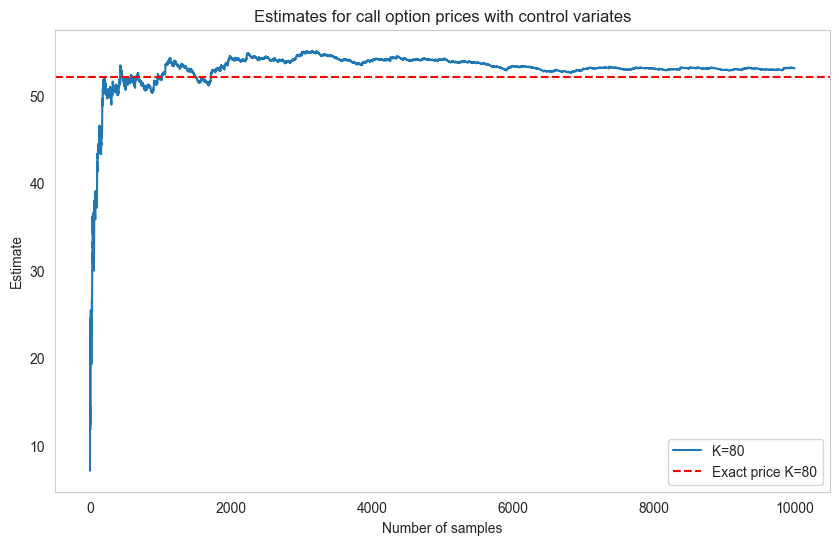

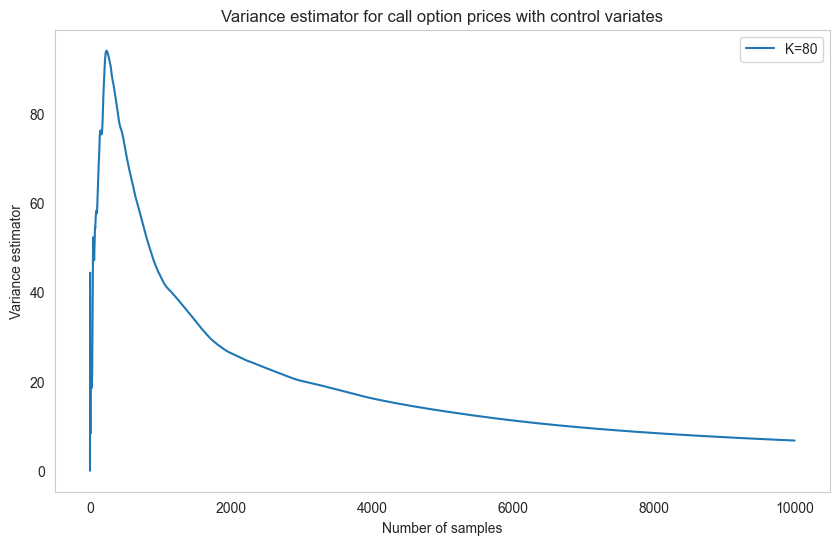


K = 120
Last Variance Estimator Control Variates: 2.4308
Last Estimator Control Variates: 41.5646


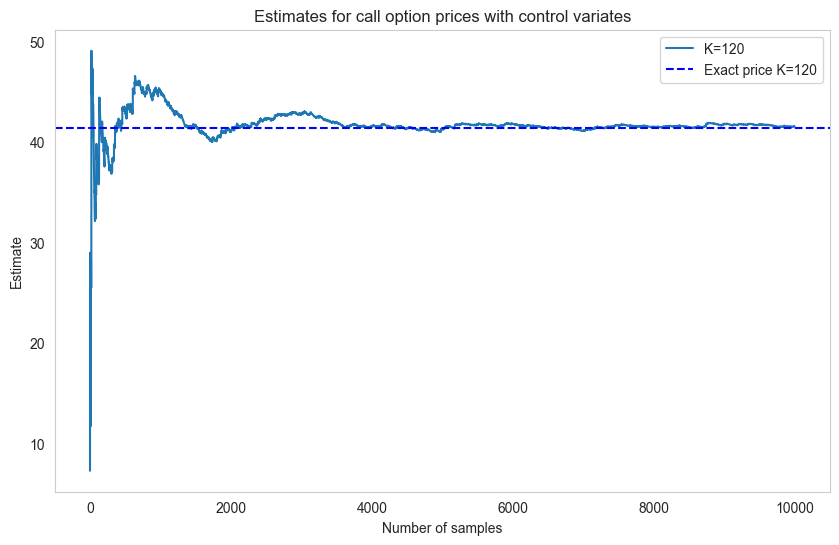

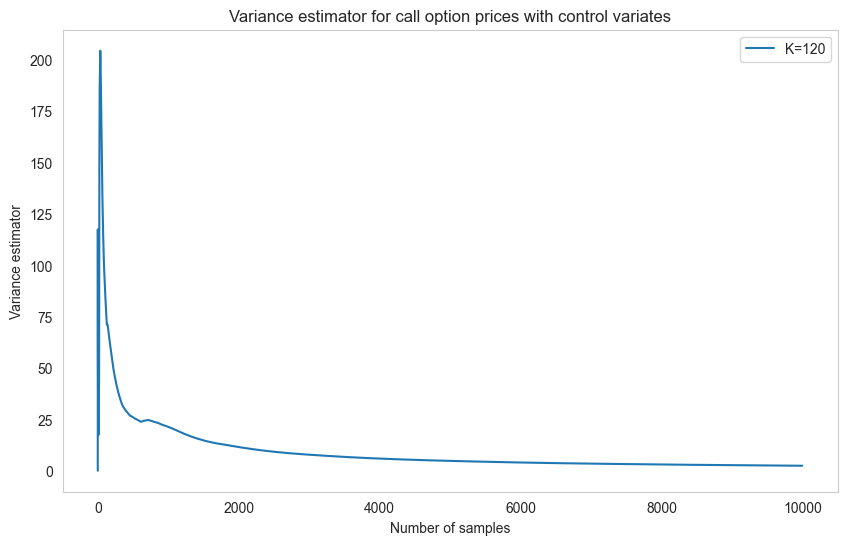

In [17]:
for K,exact_control in zip(Ks, exact_controls):
    Z = np.random.randn(n)
    STi = []
    for Tt in Ts:
        STi.append(S0 * np.exp(sigma * np.sqrt(Tt) * Z + (r - 0.5 * sigma**2) * Tt))
    mean_STi = np.mean(STi, axis=0)
    geometric_mean_STi = np.exp(np.mean(np.log(STi), axis=0))
    payoff = discount * np.maximum(mean_STi - K, 0)
    adjusted_payoff = payoff - beta * (geometric_mean_STi - exact_control)
    adjusted_cumsum = np.cumsum(adjusted_payoff)
    adjusted_estimators = adjusted_cumsum / np.arange(1, n + 1)
    adjusted_var_estimators = np.cumsum((adjusted_estimators - cumulated_mean(adjusted_estimators))**2)/divider
    print(f"\nK = {K}")
    print(f"Last Variance Estimator Control Variates: {adjusted_var_estimators[-1]:.4f}")
    print(f"Last Estimator Control Variates: {adjusted_estimators[-1]:.4f}")
    plt.figure(figsize=(10, 6))
    plt.plot(adjusted_estimators, label=f"K={K}")
    if K == K_low:
        plt.axhline(exact_estimator[0], color='red', linestyle='--', label=f"Exact price K={K}")
    else:
        plt.axhline(exact_estimator[1], color='blue', linestyle='--', label=f"Exact price K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Estimate")
    plt.title("Estimates for call option prices with control variates")
    plt.legend()
    plt.grid()
    plt.show()
    plt.figure(figsize=(10, 6))
    plt.plot(adjusted_var_estimators, label=f"K={K}")
    plt.xlabel("Number of samples")
    plt.ylabel("Variance estimator")
    plt.title("Variance estimator for call option prices with control variates")
    plt.legend()
    plt.grid()
    plt.show()

ufff, that was difficult and long to implement. I hope I did it correctly.

## 3. mix 
Using a mixed Monte Carlo method, propose an approximation method (in the B-S model for $T=10$) for the value:
$$
\mathbb{E}_P \left[ e^{-rT} (K_1 - S_5 - S_{10})^+ \mathbf{1}_{\#\{k \in \{1,2,\dots,10\}: S_k > K_2\} \ge 5} \right].
$$

This is the price of an option with payoff $(K_1 - S_5 - S_{10})^+$, provided that the stock price process crosses level $K_2$ at least five times within moments $1, \dots, 10$.

Assume $S_0 = 100$, $\sigma = 1$, $r = 0.1$, $K_1 = 200$, $K_2 = 100$.

Provide the estimated price value and the variance estimator $S_n^2$ of the proposed estimator. Compare with "pure" MC.
